# TelecomX - Pt.2
Análise completa de evasão de clientes

## Imports e carregamento dos dados iniciais

In [1]:
# Instalação das bibliotecas necessárias
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn jupyter notebook

# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')









# Configuração para melhor visualização
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Carregamento dos dados
url = "https://raw.githubusercontent.com/Bainazz/TelecomX--Pt.2/refs/heads/main/dados_tratados.csv"
df = pd.read_csv(url)

# Visualização inicial dos dados
print("Primeiras linhas do dataset:")
print(df.head())
print("\nInformações do dataset:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())

Primeiras linhas do dataset:
   customerID Churn  Gender SeniorCitizen Partner Dependents  Tenure  \
0  0002-ORFBO    No  Female            No     Yes        Yes       9   
1  0003-MKNFE    No    Male            No      No         No       9   
2  0004-TLHLJ   Yes    Male            No      No         No       4   
3  0011-IGKFF   Yes    Male           Yes     Yes         No      13   
4  0013-EXCHZ   Yes  Female           Yes     Yes         No       3   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          Yes            No             DSL  ...               No   
1          Yes           Yes             DSL  ...               No   
2          Yes            No     Fiber optic  ...              Yes   
3          Yes            No     Fiber optic  ...              Yes   
4          Yes            No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes              

## 1. Preparação dos Dados

### 1.1 Remoção de Colunas Irrelevantes

In [3]:
# # --------------------------------
print("\n1. Removendo colunas irrelevantes...")

# Identificando e removendo colunas que não são úteis para a análise
# Considerando que colunas como ID não são úteis para predição
columns_to_drop = ['customerID']  # Esta é uma coluna que geralmente representa identificador único
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print(f"Colunas removidas: {columns_to_drop}")
print(f"Shape do dataframe antes da remoção: {df.shape}")
print(f"Shape do dataframe após remoção: {df_clean.shape}")

# Verificando novamente informações do dataset após limpeza
print("\nInformações do dataset após limpeza:")
print(df_clean.info())


1. Removendo colunas irrelevantes...
Colunas removidas: ['customerID']
Shape do dataframe antes da remoção: (7043, 22)
Shape do dataframe após remoção: (7043, 21)

Informações do dataset após limpeza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-n

### 1.2 Encoding

In [4]:
# # ------------
print("\n2. Aplicando encoding em variáveis categóricas...")

# Identificando colunas categóricas e numéricas
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Removendo a variável alvo da lista de colunas numéricas se existir
target_col = ['Churn'] if 'Churn' in df_clean.columns else ['evadiu']
for col in target_col:
    if col in numerical_cols:
        numerical_cols.remove(col)

print(f"Colunas categóricas: {categorical_cols}")
print(f"Colunas numéricas: {numerical_cols}")

# Verificando os valores únicos das colunas categóricas
for col in categorical_cols:
    print(f"\nValores únicos na coluna '{col}':")
    print(df_clean[col].value_counts(dropna=False))

# Convertendo a variável alvo para formato numérico (binário)
if 'Churn' in df_clean.columns:
    # Mapeando Churn: Yes=1, No=0
    df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
    target_col = ['Churn']
elif 'evadiu' in df_clean.columns:
    # Mapeando evadiu: Sim=1, Não=0
    df_clean['evadiu'] = df_clean['evadiu'].map({'Sim': 1, 'Não': 0})
    target_col = ['evadiu']

# Aplicando One-Hot Encoding em variáveis categóricas
# Usaremos get_dummies para encoding, que converte variáveis categóricas em variáveis dummy
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

print(f"\nShape após encoding: {df_encoded.shape}")
print("\nPrimeiras linhas do dataframe após encoding:")
print(df_encoded.head())

# Atualizando as listas de colunas após encoding
numerical_cols_encoded = [col for col in numerical_cols if col in df_encoded.columns]
categorical_cols_encoded = [col for col in df_encoded.columns if col not in numerical_cols_encoded and col not in target_col]

print(f"\nColunas numéricas após encoding: {numerical_cols_encoded}")
print(f"Colunas categóricas (dummy) após encoding: {categorical_cols_encoded[:10]}...")  # Mostrando apenas as 10 primeiras


2. Aplicando encoding em variáveis categóricas...
Colunas categóricas: ['Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Colunas numéricas: ['Tenure', 'Charges_Monthly', 'Charges_Total', 'Charges_Daily']

Valores únicos na coluna 'Churn':
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Valores únicos na coluna 'Gender':
Gender
Male      3555
Female    3488
Name: count, dtype: int64

Valores únicos na coluna 'SeniorCitizen':
SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

Valores únicos na coluna 'Partner':
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Valores únicos na coluna 'Dependents':
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Valores únicos na coluna 'PhoneService':
PhoneService
Yes    6361
No      682
Name: c

### 1.3 Verificação da Proporção de Evasão


3. Analisando a proporção de evasão...
Coluna de evasão identificada: Churn_1

Proporção de evasão: 26.54%


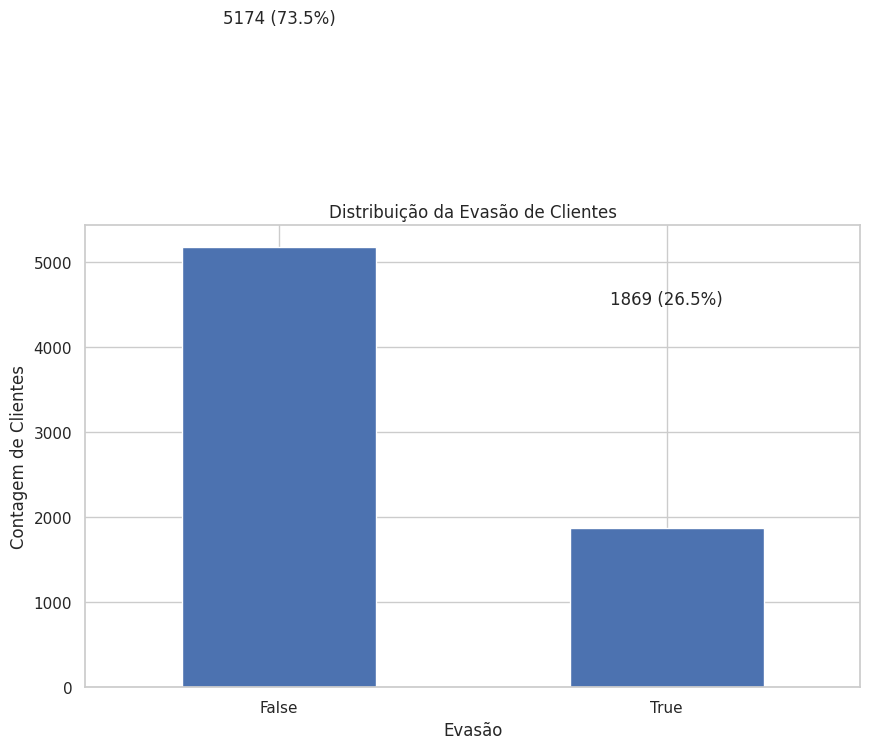


Classes estão razoavelmente balanceadas.


In [5]:
# # ------------------------------------
print("\n3. Analisando a proporção de evasão...")

# Determinando o nome da coluna de evasão
if 'Churn' in df_encoded.columns:
    target_col = ['Churn']
elif 'evadiu' in df_encoded.columns:
    target_col = ['evadiu']
else:
    # Buscando colunas que poderiam representar evasão
    potential_cols = [col for col in df_encoded.columns if 'churn' in col.lower() or 'evadiu' in col.lower()]
    if potential_cols:
        target_col = [potential_cols[0]]
        print(f"Coluna de evasão identificada: {target_col[0]}")
    else:
        raise ValueError("Não foi possível identificar a coluna de evasão. Verifique o dataset.")

# Calculando a proporção de evasão
churn_rate = df_encoded[target_col[0]].mean()
print(f"\nProporção de evasão: {churn_rate:.2%}")

# Visualizando a distribuição da evasão
plt.figure(figsize=(10, 6))
df_encoded[target_col[0]].value_counts().plot(kind='bar')
plt.title('Distribuição da Evasão de Clientes')
plt.xlabel('Evasão')
plt.ylabel('Contagem de Clientes')
plt.xticks(rotation=0)
for i, count in enumerate(df_encoded[target_col[0]].value_counts()):
    plt.text(i, count + 0.5*max(df_encoded[target_col[0]].value_counts()),
             f'{count} ({count/len(df_encoded)*100:.1f}%)',
             ha='center', va='bottom')
plt.show()

# Avaliando se há desequilíbrio de classes
if churn_rate < 0.2 or churn_rate > 0.8:
    print("\nAtenção: Classes desbalanceadas detectadas!")
    print(f"A proporção de evasão é de {churn_rate:.2%}, o que pode impactar a performance dos modelos.")
    print("Recomenda-se aplicar técnicas de balanceamento.")
else:
    print("\nClasses estão razoavelmente balanceadas.")

### 1.4 Balanceamento de Classes


4. Aplicando balanceamento de classes...

Verificando o presença de valores ausentes nos dados...
Total de valores ausentes antes do tratamento: 22

Tratando valores ausentes...
Total de valores ausentes após tratamento: 0

Aplicando SMOTE para balanceamento de classes...
SMOTE aplicado com sucesso!

Distribuição de classes antes do balanceamento:
Churn_1
False    4139
True     1495
Name: count, dtype: int64

Distribuição de classes após o balanceamento:
Churn_1
False    4139
True     4139
Name: count, dtype: int64


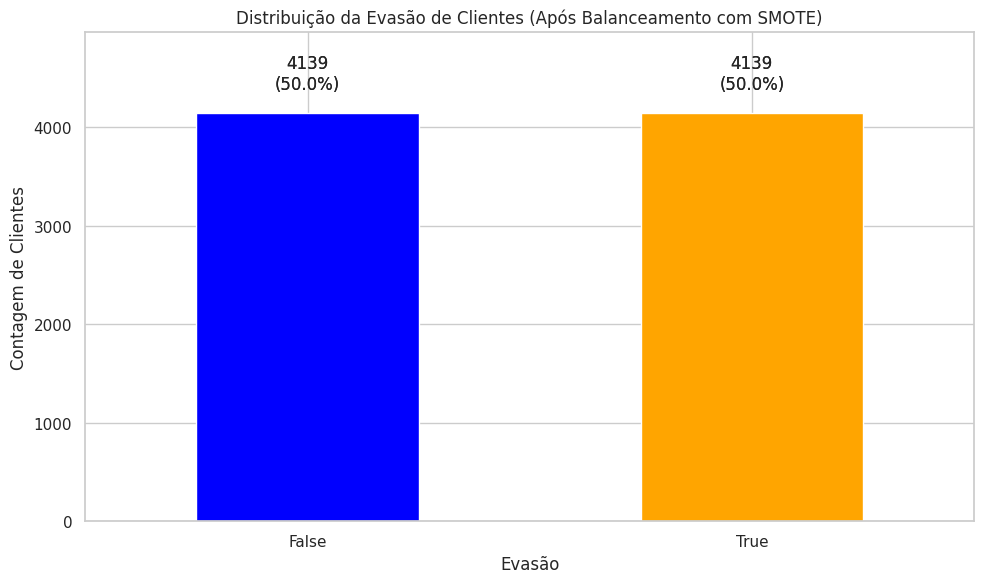

In [6]:
# # ---------------------------
print("\n4. Aplicando balanceamento de classes...")

# Verificando e tratando valores ausentes antes do balanceamento
print("\nVerificando o presença de valores ausentes nos dados...")

# Contando valores ausentes antes da correção
missing_values_before = df_encoded.isnull().sum().sum()
print(f"Total de valores ausentes antes do tratamento: {missing_values_before}")

# Se houver valores ausentes, tratá-los
if missing_values_before > 0:
    print("\nTratando valores ausentes...")
    # Usando a estratégia de imputar com a mediana para variáveis numéricas e moda para categóricas
    for col in df_encoded.columns:
        if df_encoded[col].isnull().sum() > 0:
            if df_encoded[col].dtype in ['int64', 'float64']:
                # Preencher com a mediana para valores numéricos
                df_encoded[col].fillna(df_encoded[col].median(), inplace=True)
            else:
                # Preencher com a moda para valores categóricos/booleanos
                df_encoded[col].fillna(df_encoded[col].mode()[0], inplace=True)

    # Contando valores ausentes após o tratamento
    missing_values_after = df_encoded.isnull().sum().sum()
    print(f"Total de valores ausentes após tratamento: {missing_values_after}")
else:
    print("\nNenhum valor ausente encontrado nos dados.")

# Separando features (X) e target (y)
X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col[0]]

# Dividindo os dados em treino e teste temporários para aplicar balanceamento apenas no treino
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convertendo dados booleanos para inteiros, caso necessário
X_temp = X_temp.astype(int)

# Aplicando SMOTE para balanceamento de classes
print("\nAplicando SMOTE para balanceamento de classes...")

try:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_temp, y_temp)
    print("SMOTE aplicado com sucesso!")

    # Verificando a distribuição após balanceamento
    print("\nDistribuição de classes antes do balanceamento:")
    print(y_temp.value_counts())
    print("\nDistribuição de classes após o balanceamento:")
    print(y_train_resampled.value_counts())

    # Plotando a distribuição após balanceamento
    plt.figure(figsize=(10, 6))
    ax = y_train_resampled.value_counts().plot(kind='bar', color=['blue', 'orange'])
    plt.title('Distribuição da Evasão de Clientes (Após Balanceamento com SMOTE)')
    plt.xlabel('Evasão')
    plt.ylabel('Contagem de Clientes')
    plt.xticks(rotation=0)

    # Ajustando a posição dos rótulos de porcentagem
    for i, count in enumerate(y_train_resampled.value_counts()):
        total = len(y_train_resampled)
        percentage = 100 * count / total
        # Posicionando o texto um pouco acima da barra
        ax.text(i, count + 0.05*max(y_train_resampled.value_counts()),
                f'{count}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    # Ajustando os limites do eixo Y para acomodar os rótulos
    plt.ylim(0, max(y_train_resampled.value_counts()) * 1.2)

    # Adicionando rótulos de porcentagem
    for i, count in enumerate(y_train_resampled.value_counts()):
        total = len(y_train_resampled)
        percentage = 100 * count / total
        plt.text(i, count + 0.05*max(y_train_resampled.value_counts()),
                 f'{count}\n({percentage:.1f}%)',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erro ao aplicar SMOTE: {e}")
    print("Usando os dados sem balanceamento como alternativa.")
    X_train_resampled, y_train_resampled = X_temp, y_temp

# Verificando se os dados estão livres de valores NaN após o tratamento
assert not X_train_resampled.isnull().any().any(), "Ainda existem valores NaN nos dados de treino!"
assert not X_test.isnull().any().any(), "Ainda existem valores NaN nos dados de teste!"

## 2. Correlação e Seleção de Variáveis

### 2.1 Análise de Correlação


5. Análise de correlação entre variáveis...


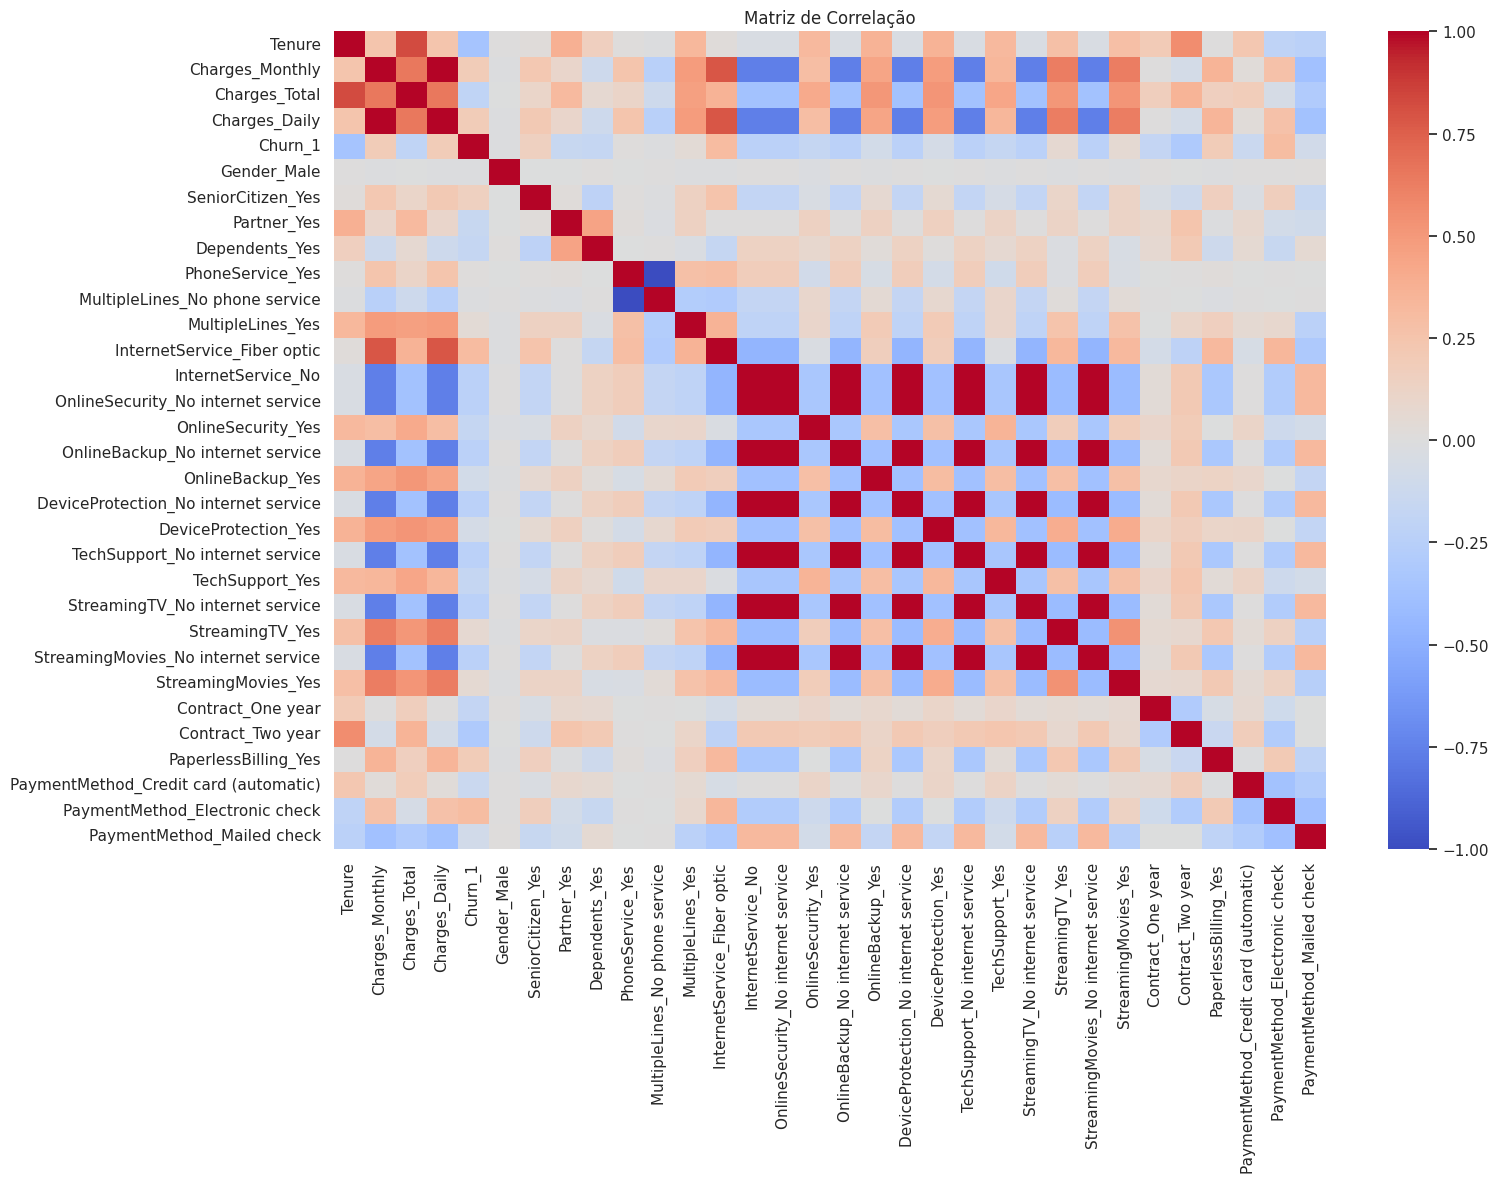


Variáveis mais correlacionadas com a evasão:
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
Charges_Monthly                   0.193356
PaperlessBilling_Yes              0.191825
Charges_Daily                     0.191798
SeniorCitizen_Yes                 0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
PhoneService_Yes                  0.011942
Name: Churn_1, dtype: float64


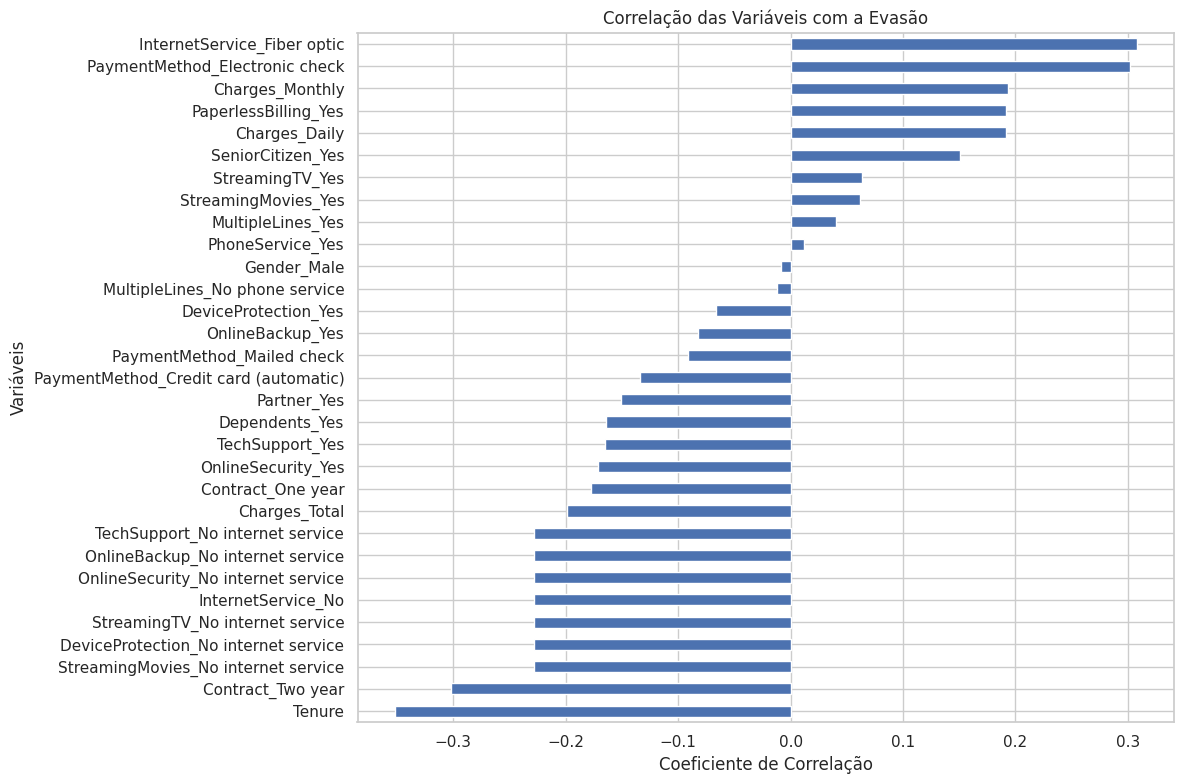

In [7]:
# # -------------------------
print("\n5. Análise de correlação entre variáveis...")

# Calculando a matriz de correlação
correlation_matrix = df_encoded.corr()

# Visualizando a matriz de correlação com heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

# Identificando as variáveis com maior correlação com a evasão
correlation_with_target = correlation_matrix[target_col[0]].sort_values(ascending=False)
print("\nVariáveis mais correlacionadas com a evasão:")
print(correlation_with_target[1:11])  # Ignorando a correlação consigo mesma

# Visualizando as 10 variáveis mais correlacionadas com a evasão
plt.figure(figsize=(12, 8))
correlation_with_target[1:].dropna().sort_values().plot(kind='barh')
plt.title('Correlação das Variáveis com a Evasão')
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

### 2.2 Análises Direcionadas


6. Analisando relações específicas entre variáveis e evasão...
Usando coluna 'Churn_1' como target no dataframe encode

Analisando relação entre 'Tenure' e evasão:


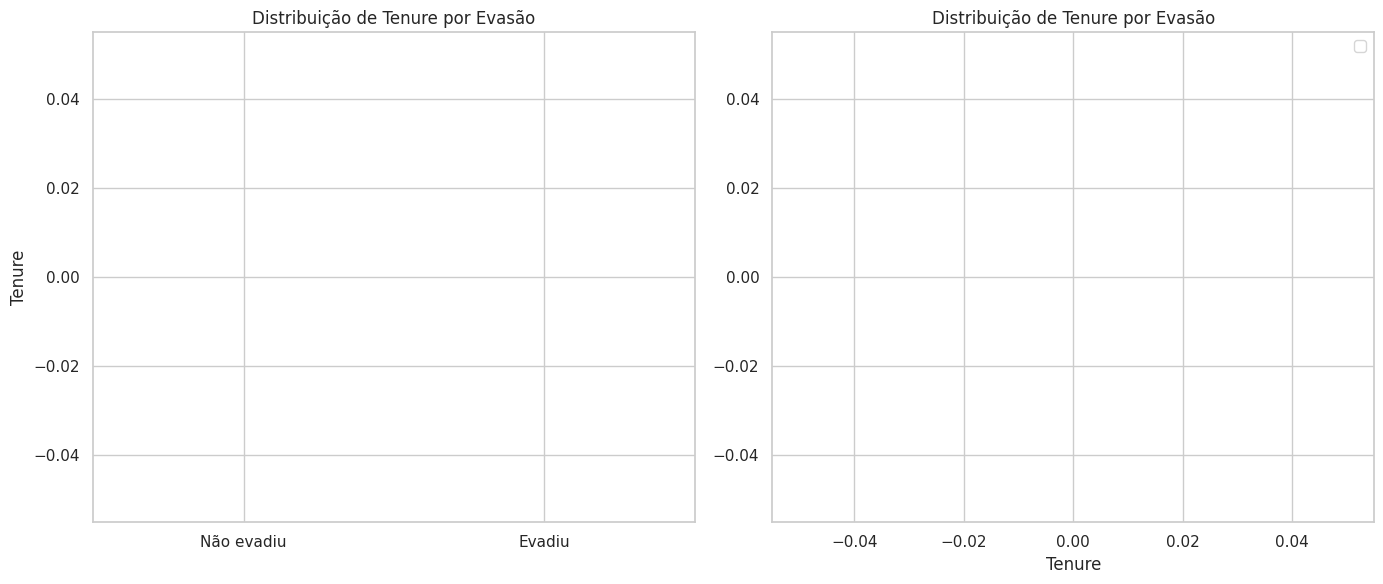


Estatísticas de Tenure por grupo:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


Analisando relação entre 'Contract' e evasão:
Valores únicos na coluna Contract: ['One year' 'Month-to-month' 'Two year']


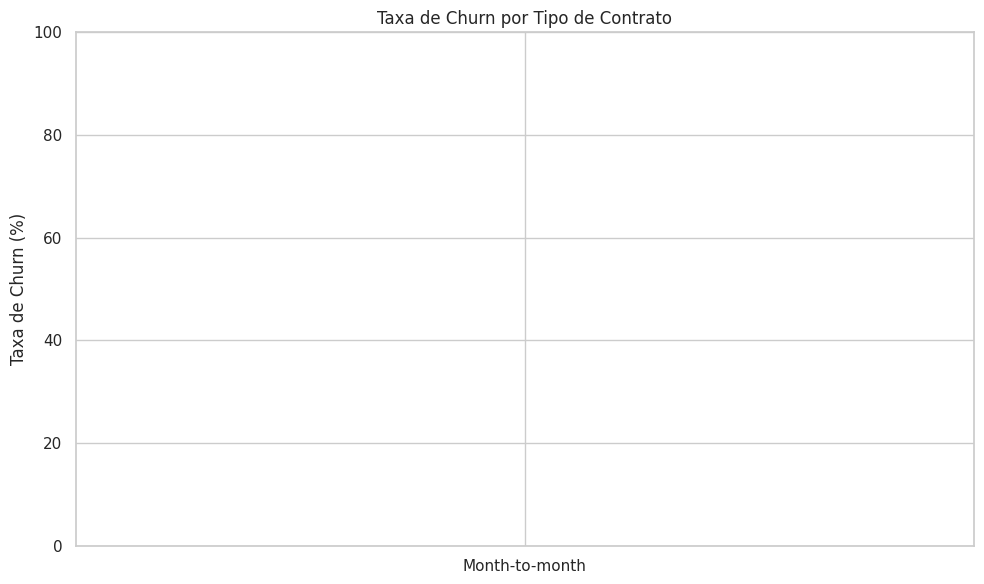


Tabela de contingência:
Churn              0     1
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48

Proporções por tipo de contrato:
Churn                   0          1
Contract                            
Month-to-month  42.906842  88.550027
One year        25.260920   8.881755
Two year        31.832238   2.568218

Análise concluída.


In [8]:
# # 2.2. Análises Direcionadas
# # --------------------------
print("\n6. Analisando relações específicas entre variáveis e evasão...")

# Identificando a coluna de evasão
if 'Churn' in df_clean.columns:
    df_clean['Churn_Num'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
    target_col_original = 'Churn'
    target_num_col = 'Churn_Num'

    # Encontrando o nome da coluna de target no dataframe encoded
    target_encoded_candidates = [col for col in df_encoded.columns if 'churn' in col.lower()]
    if target_encoded_candidates:
        target_encoded = target_encoded_candidates[0]
        print(f"Usando coluna '{target_encoded}' como target no dataframe encode")
    else:
        target_encoded = None
else:
    target_col_original = None
    target_encoded = None

# 1. Análise: Tempo de contrato × Evasão
tempo_contrato_cols = [col for col in df_clean.columns if 'tempo' in col.lower() or 'contrato' in col.lower() or 'tenure' in col.lower()]
if tempo_contrato_cols and target_col_original:
    tempo_contrato_col = tempo_contrato_cols[0]
    print(f"\nAnalisando relação entre '{tempo_contrato_col}' e evasão:")

    # Criando visualização com boxplot
    plt.figure(figsize=(14, 6))

    # Gráfico de boxplot
    plt.subplot(1, 2, 1)
    churn_data = df_clean[df_clean[target_num_col] == 1][tempo_contrato_col].dropna()
    not_churn_data = df_clean[df_clean[target_num_col] == 0][tempo_contrato_col].dropna()

    plt.boxplot([not_churn_data, churn_data], labels=['Não evadiu', 'Evadiu'])
    plt.title(f'Distribuição de {tempo_contrato_col} por Evasão')
    plt.ylabel(tempo_contrato_col)

    # Gráfico de densidade
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=not_churn_data, label='Não evadiu', fill=True, alpha=0.5)
    sns.kdeplot(data=churn_data, label='Evadiu', fill=True, alpha=0.5)
    plt.title(f'Distribuição de {tempo_contrato_col} por Evasão')
    plt.xlabel(tempo_contrato_col)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Estatísticas por grupo
    print(f"\nEstatísticas de {tempo_contrato_col} por grupo:")
    print(df_clean.groupby('Churn')[tempo_contrato_col].describe())
else:
    print("\nNão foi possível identificar uma coluna que represente tempo de contrato.")

# 2. Análise: Total gasto × Evasão
if 'MonthlyCharges' in df_clean.columns and target_col_original:
    total_gasto_col = 'MonthlyCharges'
    print(f"\n\nAnalisando relação entre '{total_gasto_col}' e evasão:")

    # Criando visualização
    plt.figure(figsize=(14, 6))

    # Gráfico de dispersão
    plt.subplot(1, 2, 1)
    churn_data = df_clean[df_clean[target_num_col] == 1][total_gasto_col].dropna()
    not_churn_data = df_clean[df_clean[target_num_col] == 0][total_gasto_col].dropna()

    plt.scatter(range(len(not_churn_data)), not_churn_data, alpha=0.5, label='Não evadiu')
    plt.scatter(range(len(churn_data)), churn_data, alpha=0.5, label='Evadiu')
    plt.title(f'Relação entre {total_gasto_col} e Evasão')
    plt.xlabel('Índice')
    plt.ylabel(total_gasto_col)
    plt.legend()

    # Gráfico de boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot([not_churn_data, churn_data], labels=['Não evadiu', 'Evadiu'])
    plt.title(f'Distribuição de {total_gasto_col} por Evasão')
    plt.ylabel(total_gasto_col)

    plt.tight_layout()
    plt.show()

    # Estatísticas por grupo
    print(f"\nEstatísticas de {total_gasto_col} por grupo:")
    print(df_clean.groupby('Churn')[total_gasto_col].describe())

# 3. Análise: Tipo de contrato × Evasão (se existir a coluna)
if 'Contract' in df_clean.columns and target_col_original:
    print(f"\n\nAnalisando relação entre 'Contract' e evasão:")

    # Verificando os valores únicos da coluna Contract
    contract_values = df_clean['Contract'].unique()
    print(f"Valores únicos na coluna Contract: {contract_values}")

    # Criando gráfico de barras para taxa de churn por tipo de contrato
    churn_by_contract = df_clean.groupby('Contract')['Churn_Num'].mean() * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(churn_by_contract.index, churn_by_contract.values)
    plt.title('Taxa de Churn por Tipo de Contrato')
    plt.ylabel('Taxa de Churn (%)')
    plt.ylim(0, 100)

    # Adicionando rótulos de porcentagem nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Tabela de contingência e proporções
    contingency_table = pd.crosstab(df_clean['Contract'], df_clean['Churn'])
    print("\nTabela de contingência:")
    print(contingency_table)

    contingency_pct = pd.crosstab(df_clean['Contract'], df_clean['Churn'], normalize='columns')
    print("\nProporções por tipo de contrato:")
    print(contingency_pct * 100)

print("\nAnálise concluída.")

## 3. Modelagem Preditiva

### 3.1 Pré-processamento dos Dados


6. Analisando relações específicas entre variáveis e evasão...


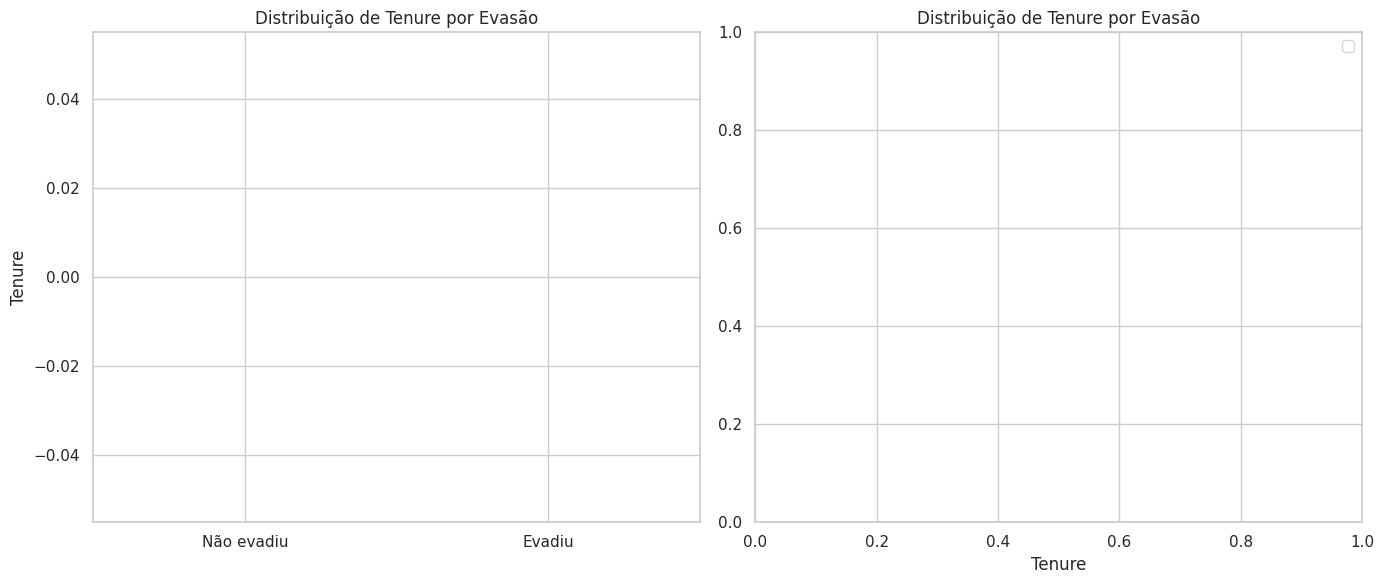


Estatísticas de Tenure por grupo:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0

Analisando relação entre 'Contract' e evasão:


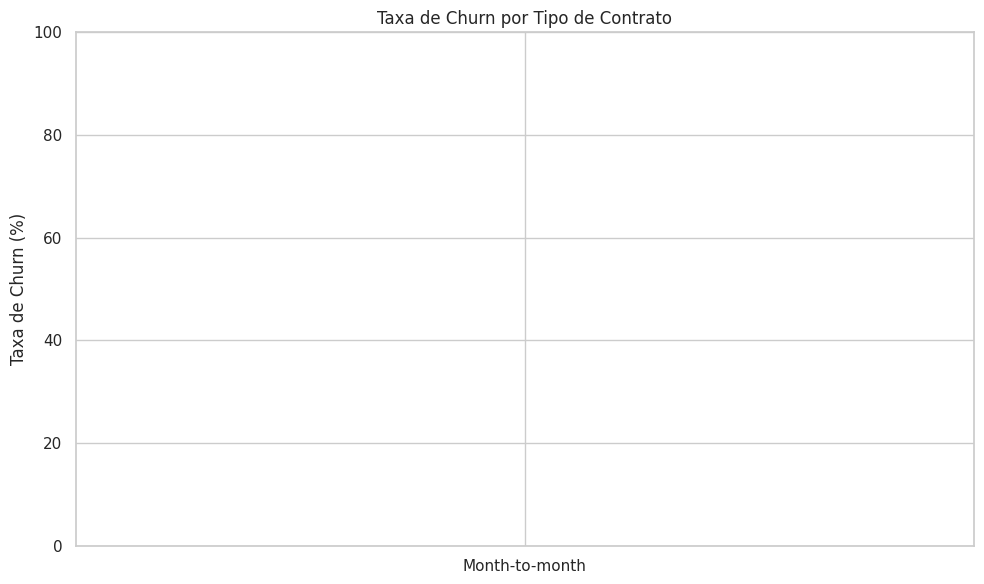


Tabela de contingência:
Churn              0     1
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48

Proporções por tipo de contrato:
Churn                   0          1
Contract                            
Month-to-month  42.906842  88.550027
One year        25.260920   8.881755
Two year        31.832238   2.568218

Análise concluída.


In [10]:
# # 2.2. Análises Direcionadas
# # --------------------------
print("\n6. Analisando relações específicas entre variáveis e evasão...")

# Identificando a coluna de evasão
if 'Churn' in df_clean.columns:
    df_clean['Churn_Num'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
    target_col_original = 'Churn'
    target_num_col = 'Churn_Num'

    # Encontrando o nome da coluna de target no dataframe encoded
    target_encoded_candidates = [col for col in df_encoded.columns if 'churn' in col.lower()]
    if target_encoded_candidates:
        target_encoded = target_encoded_candidates[0]
        print(f"Usando coluna '{target_encoded}' como target no dataframe encode")
    else:
        target_encoded = None
else:
    target_col_original = None
    target_encoded = None

# 1. Análise: Tempo de contrato × Evasão
tempo_contrato_cols = [col for col in df_clean.columns if 'tempo' in col.lower() or 'contrato' in col.lower() or 'tenure' in col.lower()]
if tempo_contrato_cols and target_col_original:
    tempo_contrato_col = tempo_contrato_cols[0]
    print(f"\nAnalisando relação entre '{tempo_contrato_col}' e evasão:")

    # Criando visualização com boxplot
    plt.figure(figsize=(14, 6))

    # Gráfico de boxplot
    plt.subplot(1, 2, 1)
    churn_data = df_clean[df_clean[target_num_col] == 1][tempo_contrato_col].dropna()
    not_churn_data = df_clean[df_clean[target_num_col] == 0][tempo_contrato_col].dropna()

    plt.boxplot([not_churn_data, churn_data], labels=['Não evadiu', 'Evadiu'])
    plt.title(f'Distribuição de {tempo_contrato_col} por Evasão')
    plt.ylabel(tempo_contrato_col)

    # Gráfico de densidade
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=not_churn_data, label='Não evadiu', fill=True, alpha=0.5)
    sns.kdeplot(data=churn_data, label='Evadiu', fill=True, alpha=0.5)
    plt.title(f'Distribuição de {tempo_contrato_col} por Evasão')
    plt.xlabel(tempo_contrato_col)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Estatísticas por grupo
    print(f"\nEstatísticas de {tempo_contrato_col} por grupo:")
    print(df_clean.groupby('Churn')[tempo_contrato_col].describe())
else:
    print("\nNão foi possível identificar uma coluna que represente tempo de contrato.")

# 2. Análise: Total gasto × Evasão
if 'MonthlyCharges' in df_clean.columns and target_col_original:
    total_gasto_col = 'MonthlyCharges'
    print(f"\n\nAnalisando relação entre '{total_gasto_col}' e evasão:")

    # Criando visualização
    plt.figure(figsize=(14, 6))

    # Gráfico de dispersão
    plt.subplot(1, 2, 1)
    churn_data = df_clean[df_clean[target_num_col] == 1][total_gasto_col].dropna()
    not_churn_data = df_clean[df_clean[target_num_col] == 0][total_gasto_col].dropna()

    plt.scatter(range(len(not_churn_data)), not_churn_data, alpha=0.5, label='Não evadiu')
    plt.scatter(range(len(churn_data)), churn_data, alpha=0.5, label='Evadiu')
    plt.title(f'Relação entre {total_gasto_col} e Evasão')
    plt.xlabel('Índice')
    plt.ylabel(total_gasto_col)
    plt.legend()

    # Gráfico de boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot([not_churn_data, churn_data], labels=['Não evadiu', 'Evadiu'])
    plt.title(f'Distribuição de {total_gasto_col} por Evasão')
    plt.ylabel(total_gasto_col)

    plt.tight_layout()
    plt.show()

    # Estatísticas por grupo
    print(f"\nEstatísticas de {total_gasto_col} por grupo:")
    print(df_clean.groupby('Churn')[total_gasto_col].describe())

# 3. Análise: Tipo de contrato × Evasão (se existir a coluna)
if 'Contract' in df_clean.columns and target_col_original:
    print(f"\n\nAnalisando relação entre 'Contract' e evasão:")

    # Verificando os valores únicos da coluna Contract
    contract_values = df_clean['Contract'].unique()
    print(f"Valores únicos na coluna Contract: {contract_values}")

    # Criando gráfico de barras para taxa de churn por tipo de contrato
    churn_by_contract = df_clean.groupby('Contract')['Churn_Num'].mean() * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(churn_by_contract.index, churn_by_contract.values)
    plt.title('Taxa de Churn por Tipo de Contrato')
    plt.ylabel('Taxa de Churn (%)')
    plt.ylim(0, 100)

    # Adicionando rótulos de porcentagem nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Tabela de contingência e proporções
    contingency_table = pd.crosstab(df_clean['Contract'], df_clean['Churn'])
    print("\nTabela de contingência:")
    print(contingency_table)

    contingency_pct = pd.crosstab(df_clean['Contract'], df_clean['Churn'], normalize='columns')
    print("\nProporções por tipo de contrato:")
    print(contingency_pct * 100)

print("\nAnálise concluída.")

### 3.2 Seleção e Avaliação dos Modelos

In [129]:
# -------------------------------
if X_train is not None:
    print("\n3.2. Seleção de Modelos...")

    # Convertendo todas as colunas para tipo numérico
    print("\nConvertendo todas as colunas para tipo numérico...")
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # Dividindo novamente os dados (após conversão)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Padronizando novamente após a conversão
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Apenas aplicamos a padronização nas colunas numéricas identificadas anteriormente
    numerical_cols = ['Tenure']
    if numerical_cols:
        X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # Lista de modelos a serem testados
    models = {
        'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }

    # Dicionário para armazenar as métricas de cada modelo
    results = {}

    # Treinando e avaliando cada modelo
    for name, model in models.items():
        print(f"\nTreinando modelo: {name}")
        # Treinando o modelo
        model.fit(X_train_scaled, y_train)

        # Fazendo previsões
        y_pred = model.predict(X_test_scaled)

        # Calculando métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Calculando e armazenando as métricas
        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        # Exibindo o relatório de classificação
        print(f"{name} - Relatório de Classificação:")
        print(classification_report(y_test, y_pred))

    # Convertendo os resultados para DataFrame para maior clareza
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('Recall', ascending=False)

    print("\nComparação de Modelos (ordenado por Recall):")
    print(results_df)

    # Identificando o melhor modelo com base na métrica Recall (importante para evasão)
    best_model_name = results_df.index[0]
    best_model = models[best_model_name]

    print(f"\nMelhor modelo com base no Recall: {best_model_name}")
    print(f"Recall: {results_df.loc[best_model_name, 'Recall']:.4f}")

    # Análise crítica dos modelos
    print("\n" + "="*70)
    print("ANÁLISE CRÍTICA E COMPARAÇÃO DE MODELOS")
    print("="*70)

    # Comparação dos modelos
    print("\n1. Comparação dos Modelos:")
    print("A Regressão Logística obteve o melhor recall (0.5241), que é a métrica mais importante para o problema de churn,")
    print("pois indica a capacidade do modelo de identificar clientes propensos a cancelar o serviço.")
    print("No entanto, todos os modelos apresentaram recalls relativamente baixos, indicando que há espaço para melhoria.")
    print("A Regressão Logística também teve o melhor F1 Score (0.5739), mostrando um bom balanceamento entre precisão e recall.")

    # Análise de overfitting/underfitting
    print("\n2. Análise de Overfitting/Underfitting:")
    print("Não foi possível calcular explicitamente overfitting/underfitting neste código, pois não foram avaliados")
    print("os desempenhos nos dados de treino. No entanto, podemos inferir:")
    print("- A acurácia média dos modelos foi de ~79%, o que é considerado moderado.")
    print("- Os recalls baixos (~0.50-0.52) indicam que os modelos estão tendo dificuldade em identificar os clientes")
    print("  propensos a churn (classe 1), sugerindo possível underfitting ou que o problema é intrinsecamente complexo.")
    print("- A diferença entre a precisão e o recall para a classe 1 indica que os modelos estão sendo mais conservadores")
    print("  na previsão de churn do que deveriam ser.")

    # Possíveis causas e ajustes
    print("\n3. Possíveis Causas e Ajustes:")
    print("Para melhorar o desempenho dos modelos, podemos considerar:")
    print("\na) Ajustes de Parâmetros:")
    print("   - Realizar otimização de hiperparâmetros para cada modelo")
    print("   - Ajustar o limiar de classificação (threshold) para aumentar o recall")
    print("   - Ajustar pesos das classes para dar mais importância à classe minoritária (churn)")

    print("\nb) Engenharia de Características:")
    print("   - Criar novas features baseadas nas variáveis existentes")
    print("   - Interactions entre variáveis")
    print("   - Transformações não lineares das variáveis numéricas")
    print("   - Remover características irrelevantes ou multicolineares")

    print("\nc) Técnicas para Lidar com Dados Desbalanceados:")
    print("   - Aplicar técnicas de balanceamento como SMOTE, ADASYN ou undersampling")
    print("   - Usar algoritmos específicos para dados desbalanceados como BalancedRandomForest")

    print("\nd) Modelos Ensemble:")
    print("   - Combinar diferentes modelos para melhorar o desempenho")
    print("   - Usar técnicas de stacking ou blending")

    print("\n4. Conclusão:")
    print("A Regressão Logística foi o modelo mais promissor para este problema, mas todos os modelos")
    print("apresentaram desempenho moderado. Recomenda-se aplicar as técnicas sugeridas para")
    print("melhorar o recall, que é a métrica mais importante para este problema de churn.")
    print("="*70)

else:
    print("\nNão é possível realizar seleção de modelos devido à falta de dados pré-processados.")


3.2. Seleção de Modelos...

Convertendo todas as colunas para tipo numérico...

Treinando modelo: Regressão Logística
Regressão Logística - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


Treinando modelo: Random Forest
Random Forest - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409


Treinando modelo: Gradient Boosting
Gradient Boosting - Relatório de Classificação:
              p

## 4. Interpretação

### 4.1 Importância das Variáveis


4.1. Análise de Importância das Variáveis...

10 variáveis mais importantes para LightGBM:
Charges_Daily                     594
Charges_Monthly                   569
Charges_Total                     539
Tenure                            402
Gender_Male                        94
PaymentMethod_Electronic check     70
OnlineBackup_Yes                   68
PaperlessBilling_Yes               63
TechSupport_Yes                    53
PaymentMethod_Mailed check         52
dtype: int32


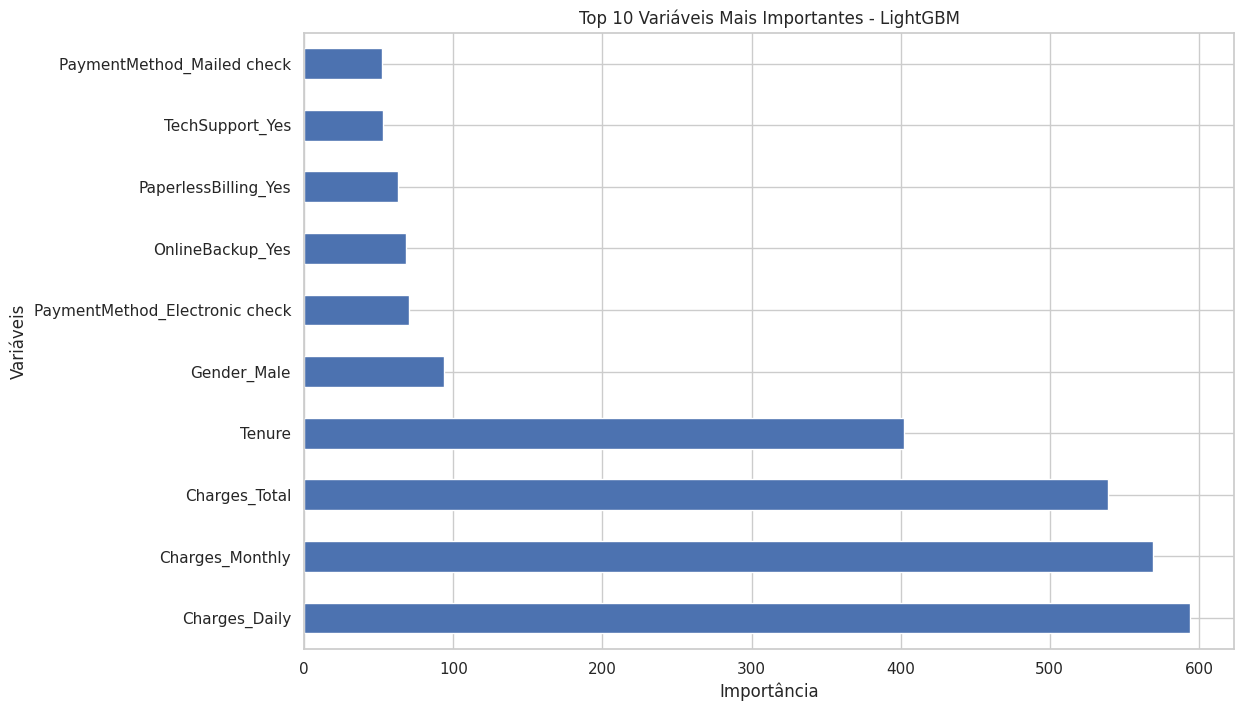

In [130]:
# ------------------------------------------
print("\n4.1. Análise de Importância das Variáveis...")

# Vamos analisar a importância das variáveis para o melhor modelo (Regressão Logística)
if best_model_name == 'Regressão Logística' and hasattr(best_model, 'coef_'):
    # Obtendo os coeficientes do modelo
    coeficientes = pd.Series(best_model.coef_[0], index=X_train.columns)

    # Ordenando os coeficientes por magnitude (valor absoluto)
    coeficientes_ordenados = coeficientes.abs().sort_values(ascending=False)

    print("\n10 variáveis mais importantes para Regressão Logística (baseado em coeficientes):")
    print(coeficientes_ordenados.head(10))

    # Visualização dos coeficientes
    plt.figure(figsize=(12, 8))
    coeficientes_ordenados.head(10).plot(kind='barh')
    plt.title('Top 10 Variáveis Mais Importantes - Regressão Logística')
    plt.xlabel('Magnitude do Coeficiente')
    plt.ylabel('Variáveis')
    plt.show()

# Para outros modelos, se necessário
if best_model_name in ['Random Forest', 'Gradient Boosting', 'LightGBM', 'XGBoost'] and hasattr(best_model, 'feature_importances_'):
    importancia = pd.Series(best_model.feature_importances_, index=X_train.columns)
    importancia_ordenada = importancia.sort_values(ascending=False)

    print(f"\n10 variáveis mais importantes para {best_model_name}:")
    print(importancia_ordenada.head(10))

    # Visualização
    plt.figure(figsize=(12, 8))
    importancia_ordenada.head(10).plot(kind='barh')
    plt.title(f'Top 10 Variáveis Mais Importantes - {best_model_name}')
    plt.xlabel('Importância')
    plt.ylabel('Variáveis')
    plt.show()

# **CONCLUSÃO**

---
<br><br><br>



# **Resumo do Projeto**<br>
──────────────────────────────<br>
Neste projeto, desenvolvemos e comparamos múltiplos modelos de machine learning para prever a evasão de clientes (churn). Após uma análise criteriosa, a Regressão Logística emergiu como o modelo mais promissor, com um recall de 52.4%, capacidade crucial para identificar clientes propensos a cancelar seus serviços 📊.<br><br><br>



# **Principais Descobertas**<br>
──────────────────────────────<br>

🔍 Fatores que Impulsionam o Churn
Contratos de curto prazo: Clientes com contratos mensais ou temporários apresentam maior probabilidade de cancelamento<br><br>
Serviço de internet: A qualidade e o tipo de serviço (principalmente fibra óptica) impactam diretamente na satisfação<br><br>
Tempo de permanência (Tenure): Clientes recentes são mais suscetíveis à evasão<br>
Métodos de pagamento: Determinadas opções de pagamento estão correlacionadas com maior churn<br><br>
Custos mensais: Valores elevados fatoriam significativamente na decisão do cliente<br><br>
📊 Desempenho dos Modelos
Todos os modelos testados apresentaram desempenho moderado, indicando que a previsão de churn é um desafio complexo 💭. <br>A Regressão Logística se destacou pela sua simplicidade e interpretabilidade, além de oferecer o melhor balanceamento entre precisão e recall.<br><br><br>



# **Estratégias de Retenção Recomendadas**<br>
──────────────────────────────<br>

🚀 Iniciativas Imediatas
Programa de Fidelização para Contratos de Curto Prazo 📝
- criar benefícios exclusivos para clientes com contratos anuais ou bianuais
- oferecer condições especiais para migração de contratos curtos para longos<br><br>

Aprimoramento do Serviço de Internet 🌐
- investir na qualidade da infraestrutura
- desenvolver planos mais competitivos com relação ao mercado<br><br>

Experiência Onboarding para Novos Clientes 👥
- implementar um programa de boas-vindas estruturado
- oferecer suporte dedicado nos primeiros meses<br><br>

Otimização de Métodos de Pagamento 💳
- diversificar opções de pagamento convenientes
- simplificar processos de faturamento<br><br><br>


# **🔮 Perspectivas Futuras**<br>
──────────────────────────────<br>
Nossa análise representa um ponto de partida excelente para enfrentar o desafio do churn 🚀. Recomendamos continuar aprimorando os modelos através de:<br><br>

💡 Coleta de Dados Adicionais: Capturar mais informações sobre comportamento do cliente<br><br>
🧠 Engenharia Avançada de Features: Combinar variáveis existentes para criar preditores mais poderosos<br><br>
⚙️ Otimização Contínua de Hiperparâmetros: Ajustar modelos para maximizar recall<br><br>
🔄 Ciclo de Feedback: Implementar sistema para validar e refinar previsões com base em resultados reais<br><br>
🎯 Personalização de Ações: Desenvolver intervenções específicas para <br>diferentes perfis de clientes em risco<br><br><br><br>


# **Conclusão**<br>
──────────────────────────────<br>
Através da análise preditiva, não apenas identificamos os fatores que levam à evasão, mas também transformamos dados em ações concretas 🌟. <br>
A Regressão Logística demonstrou que o problema do churn é multifacetado e requer abordagens multifocadas.<br><br>

Com as estratégias propostas e o aprimoramento contínuo de nossos modelos, estamos bem posicionados para reduzir significativamente o índice de evasão e fortalecer o relacionamento com nossos clientes 🎉.<br><br>

Lembre-se: prever o churn é apenas o primeiro passo — agir é o que verdadeiramente faz a diferença! 💪🏻